In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import shap
import imblearn
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from timeit import default_timer as timer

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_path = os.path.dirname(os.getcwd()) + "\_datasets"
df = pd.read_csv(data_path + "\939775908_T_ONTIME_REPORTING.csv")
df

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS
0,2018,1,1,27,2018-01-27,UA,FLL,IAH,615,602.0,-13.0,0.0,-1.0,19.0,621.0,749.0,7.0,808,756.0,-12.0,0.0,0.0,NaN,0.0,173.0,174.0,148.0,1.0,966.0,NaN,NaN,NaN,NaN,NaN,0
1,2018,1,1,27,2018-01-27,UA,SEA,SFO,618,614.0,-4.0,0.0,-1.0,16.0,630.0,808.0,5.0,831,813.0,-18.0,0.0,0.0,NaN,0.0,133.0,119.0,98.0,1.0,679.0,NaN,NaN,NaN,NaN,NaN,0
2,2018,1,1,27,2018-01-27,UA,DCA,IAH,830,828.0,-2.0,0.0,-1.0,17.0,845.0,1055.0,13.0,1107,1108.0,1.0,0.0,0.0,NaN,0.0,217.0,220.0,190.0,1.0,1208.0,NaN,NaN,NaN,NaN,NaN,0
3,2018,1,1,27,2018-01-27,UA,LAX,ORD,650,641.0,-9.0,0.0,-1.0,17.0,658.0,1230.0,12.0,1250,1242.0,-8.0,0.0,0.0,NaN,0.0,240.0,241.0,212.0,1.0,1744.0,NaN,NaN,NaN,NaN,NaN,0
4,2018,1,1,27,2018-01-27,UA,JAX,EWR,1824,1810.0,-14.0,0.0,-1.0,11.0,1821.0,2013.0,8.0,2045,2021.0,-24.0,0.0,0.0,NaN,0.0,141.0,131.0,112.0,1.0,820.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276866,2018,1,1,1,2018-01-01,WN,PHX,LAX,1420,1608.0,108.0,1.0,7.0,23.0,1631.0,1630.0,8.0,1445,1638.0,113.0,1.0,0.0,NaN,0.0,85.0,90.0,59.0,1.0,370.0,0.0,0.0,20.0,0.0,93.0,0
276867,2018,1,1,1,2018-01-01,WN,PHX,LAX,2020,2110.0,50.0,1.0,3.0,9.0,2119.0,2116.0,8.0,2050,2124.0,34.0,1.0,0.0,NaN,0.0,90.0,74.0,57.0,1.0,370.0,0.0,0.0,0.0,0.0,34.0,0
276868,2018,1,1,1,2018-01-01,WN,PHX,LAX,1230,1229.0,-1.0,0.0,-1.0,16.0,1245.0,1248.0,13.0,1305,1301.0,-4.0,0.0,0.0,NaN,0.0,95.0,92.0,63.0,1.0,370.0,NaN,NaN,NaN,NaN,NaN,0
276869,2018,1,1,1,2018-01-01,WN,PHX,LIT,1025,1026.0,1.0,0.0,0.0,14.0,1040.0,1348.0,3.0,1410,1351.0,-19.0,0.0,0.0,NaN,0.0,165.0,145.0,128.0,1.0,1136.0,NaN,NaN,NaN,NaN,NaN,0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276871 entries, 0 to 276870
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   YEAR                  276871 non-null  int64  
 1   QUARTER               276871 non-null  int64  
 2   MONTH                 276871 non-null  int64  
 3   DAY_OF_MONTH          276871 non-null  int64  
 4   FL_DATE               276871 non-null  object 
 5   OP_UNIQUE_CARRIER     276871 non-null  object 
 6   ORIGIN                276871 non-null  object 
 7   DEST                  276871 non-null  object 
 8   CRS_DEP_TIME          276871 non-null  int64  
 9   DEP_TIME              267752 non-null  float64
 10  DEP_DELAY             267254 non-null  float64
 11  DEP_DEL15             267254 non-null  float64
 12  DEP_DELAY_GROUP       267254 non-null  float64
 13  TAXI_OUT              267607 non-null  float64
 14  WHEELS_OFF            267607 non-null  float64
 15  

In [5]:
print(df.isnull().any())

YEAR                    False
QUARTER                 False
MONTH                   False
DAY_OF_MONTH            False
FL_DATE                 False
OP_UNIQUE_CARRIER       False
ORIGIN                  False
DEST                    False
CRS_DEP_TIME            False
DEP_TIME                 True
DEP_DELAY                True
DEP_DEL15                True
DEP_DELAY_GROUP          True
TAXI_OUT                 True
WHEELS_OFF               True
WHEELS_ON                True
TAXI_IN                  True
CRS_ARR_TIME            False
ARR_TIME                 True
ARR_DELAY                True
ARR_DEL15                True
CANCELLED               False
CANCELLATION_CODE        True
DIVERTED                False
CRS_ELAPSED_TIME        False
ACTUAL_ELAPSED_TIME      True
AIR_TIME                 True
FLIGHTS                 False
DISTANCE                False
CARRIER_DELAY            True
WEATHER_DELAY            True
NAS_DELAY                True
SECURITY_DELAY           True
LATE_AIRCR

In [6]:
df.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DEL15', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_AIRPORT_LANDINGS'],
      dtype='object')

In [7]:
df = df.drop(['ARR_DEL15', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'TAXI_OUT', 'WHEELS_OFF', 'ORIGIN','WHEELS_ON', 'YEAR', 'TAXI_IN', 'TAXI_OUT', 'CRS_ARR_TIME', 'ARR_DELAY', 'ARR_TIME', 'DIVERTED', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'QUARTER', 'DEP_TIME', 'DIV_AIRPORT_LANDINGS', 'DEST', 'OP_UNIQUE_CARRIER', 'CANCELLATION_CODE'], 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [8]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df = df.set_index('FL_DATE')
df = df.sort_values(by='FL_DATE')
df = df.dropna(how='all', axis='columns')
df = df.fillna(0)
df

,MONTH,DAY_OF_MONTH,DEP_DELAY,CANCELLED,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
FL_DATE,,,,,,,,,,,,
2018-01-01,1,1,53.0,0.0,121.0,1.0,1044.0,4.0,0.0,0.0,0.0,37.0
2018-01-01,1,1,-4.0,0.0,85.0,1.0,530.0,0.0,0.0,0.0,0.0,0.0
2018-01-01,1,1,-9.0,0.0,92.0,1.0,509.0,0.0,0.0,24.0,0.0,0.0
2018-01-01,1,1,570.0,0.0,35.0,1.0,164.0,565.0,0.0,0.0,0.0,0.0
2018-01-01,1,1,-7.0,0.0,106.0,1.0,642.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-31,1,31,-4.0,0.0,67.0,1.0,448.0,0.0,0.0,0.0,0.0,0.0
2018-01-31,1,31,-2.0,0.0,73.0,1.0,448.0,0.0,0.0,0.0,0.0,0.0
2018-01-31,1,31,-3.0,0.0,51.0,1.0,235.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def plot_heatmap(data):

    matrix = np.triu(data.corr())
    plt.figure(figsize=(16, 16))
    heatmap = sns.heatmap(data.corr(), annot=True, annot_kws={"fontsize": 8}, mask=matrix, linewidths=0.2, square=True)
    figure = heatmap.get_figure()
    
    return figure

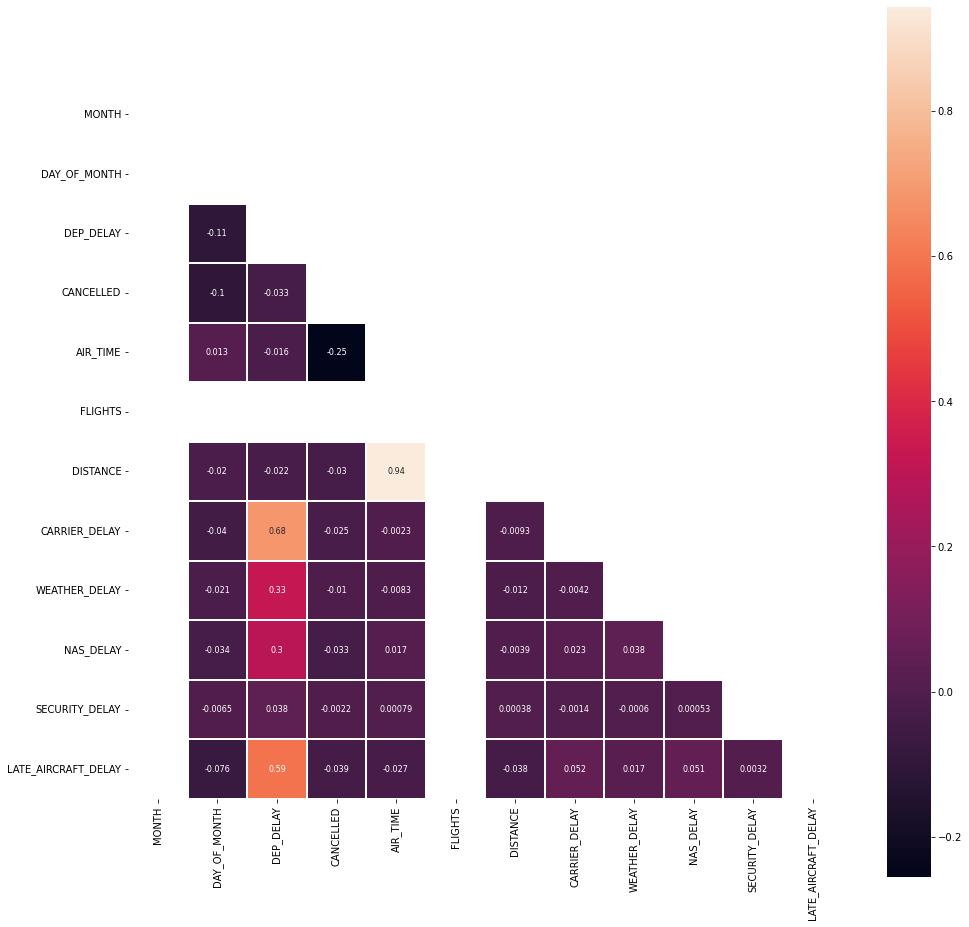

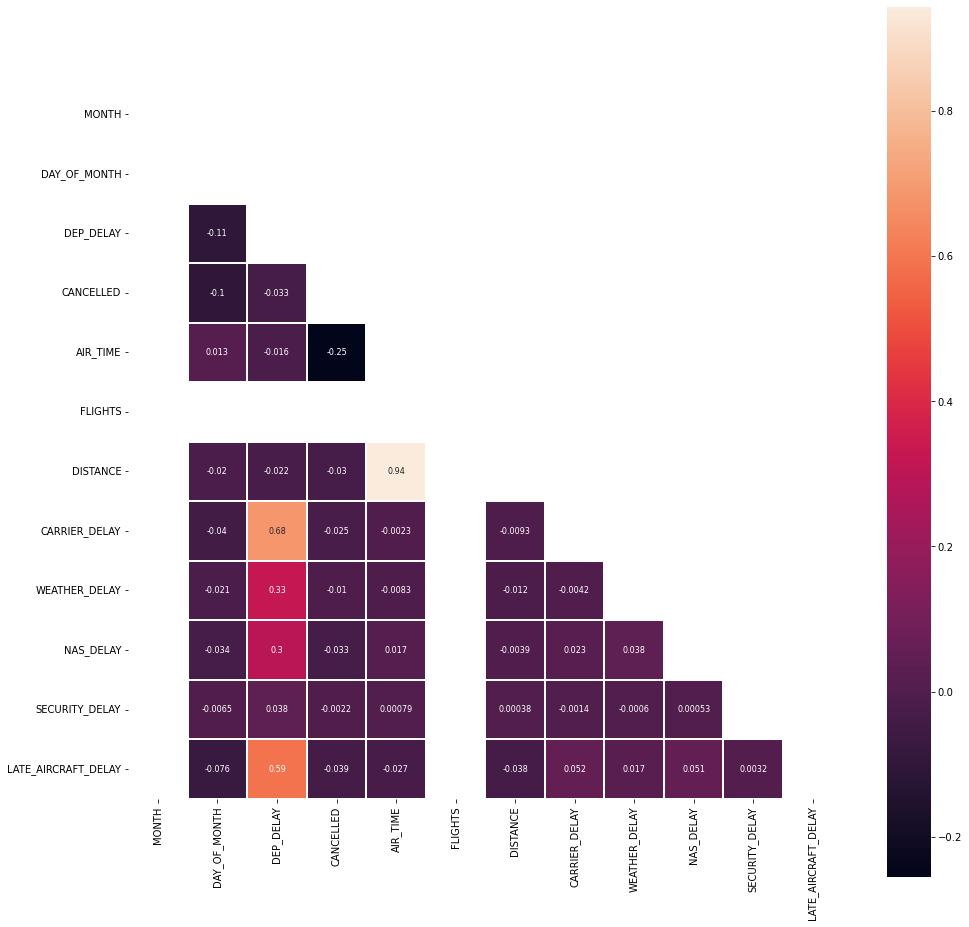

In [10]:
corr = plot_heatmap(df)
corr

In [11]:
df.shape

(276871, 12)

In [12]:
df['CANCELLED'].value_counts()

0.0    267532
1.0      9339
Name: CANCELLED, dtype: int64

In [13]:
X = df.drop('CANCELLED', 1)
y = df['CANCELLED']

under = RandomUnderSampler(sampling_strategy=0.33)
X, y = under.fit_resample(X, y)
over = RandomOverSampler(sampling_strategy=1)
X, y = over.fit_resample(X, y)

y.value_counts()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


0.0    28300
1.0    28300
Name: CANCELLED, dtype: int64

In [14]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                print('r')
                print(r)
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [15]:
models1 = {
        'RandomForestClassifier': RandomForestClassifier(),
#         'ExtraTreesClassifier': ExtraTreesClassifier(),
#         'GradientBoostingClassifier': GradientBoostingClassifier(),
#         'XGBClassifier': XGBClassifier()
          }

params1 = {
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'XGBClassifier': {'max_depth': [3,5], 'min_child_weight' : [3, 5]}
          }

In [16]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X, y, scoring='f1', n_jobs=2)

Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [17]:
helper1.score_summary(sort_by='max_score')

RandomForestClassifier
r
[0.99888801 0.99872922]
r
[0.99899402 0.99883499]
r
[0.99841219 0.9983067 ]


,estimator,min_score,mean_score,max_score,std_score,n_estimators
0,RandomForestClassifier,0.998412,0.998765,0.998994,0.000253,16
1,RandomForestClassifier,0.998307,0.998624,0.998835,0.000228,32


In [18]:
def results_kfold(X, y, regression=True):

    result_dict = {}
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    reg_columns = ['RMSE', 'MAE', 'R2']
    clf_columns = ['F1', 'PRECIS', 'RECALL', 'ROC AUC', 'T POS', 'F POS', 'F NEG', 'T NEG']
            
    if regression:

        for name,regressor in regressors:

            rmse = []
            mae = []
            r2 = []

            for train_index, test_index in cv.split(X):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                score = regressor.fit(X_train, y_train)
                prediction = score.predict(X_test)

                rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))
                mae.append(mean_absolute_error(y_test, prediction))
                r2.append(score.score(X_train, y_train))

            if name not in result_dict:
                result_dict[name] = []

            result_dict[name].append(np.mean(rmse))
            result_dict[name].append(np.mean(mae))
            result_dict[name].append(np.mean(r2))
               
        result_dict = pd.DataFrame.from_dict(result_dict, orient='index')
        result_dict.columns = reg_columns
            
    else:
        
        for name,classifier in classifiers:

            f1 = []
            precis = []
            recall = []
            roc_auc = []
            t_pos = []
            f_pos = []
            f_neg = []
            t_neg = []

            for train_index, test_index in cv.split(X):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                score = classifier.fit(X_train, y_train)
                prediction = score.predict(X_test)
                
                p_r_f1 = precision_recall_fscore_support(y_test, prediction, average='weighted')
                precis.append(p_r_f1[0])
                recall.append(p_r_f1[1])
                f1.append(p_r_f1[2])
                roc_auc.append(roc_auc_score(y_test, prediction))
          
                cm = confusion_matrix(y_test, prediction)
                t_pos.append(cm[0][0])
                f_pos.append(cm[0][1])
                f_neg.append(cm[1][0])
                t_neg.append(cm[1][1])

            if name not in result_dict:
                result_dict[name] = []

            result_dict[name].append(np.mean(f1))
            result_dict[name].append(np.mean(precis))
            result_dict[name].append(np.mean(recall))
            result_dict[name].append(np.mean(roc_auc))
            result_dict[name].append(np.mean(t_pos))
            result_dict[name].append(np.mean(f_pos))
            result_dict[name].append(np.mean(f_neg))
            result_dict[name].append(np.mean(t_neg))
            
        result_dict = pd.DataFrame.from_dict(result_dict, orient='index')
        result_dict.columns = clf_columns

    return result_dict

In [19]:
regressors = [['DecisionTreeRegressor :', DecisionTreeRegressor()],
              ['RandomForestRegressor :', RandomForestRegressor()],
              ['ExtraTreesRegressor :', ExtraTreesRegressor()],
              ['GradientBoostingRegressor :', GradientBoostingRegressor()],
              ['XGBRegressor :', XGBRegressor()]]

classifiers = [['RandomForestClassifier :', RandomForestClassifier()],
              ['ExtraTreesClassifier :', ExtraTreesClassifier()],
              ['GradientBoostingClassifier :', GradientBoostingClassifier()],
              ['XGBClassifier :', XGBClassifier()]]

In [20]:
classifier_results_kfold = results_kfold(X, y, regression=True)
classifier_results_kfold

,RMSE,MAE,R2
DecisionTreeRegressor :,0.033187,0.001138,0.999911
RandomForestRegressor :,0.031850,0.001624,0.999387
ExtraTreesRegressor :,0.030521,0.001334,0.999911
GradientBoostingRegressor :,0.035888,0.002969,0.995794
XGBRegressor :,0.032872,0.002026,0.999764


In [21]:
model = XGBClassifier()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:52:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


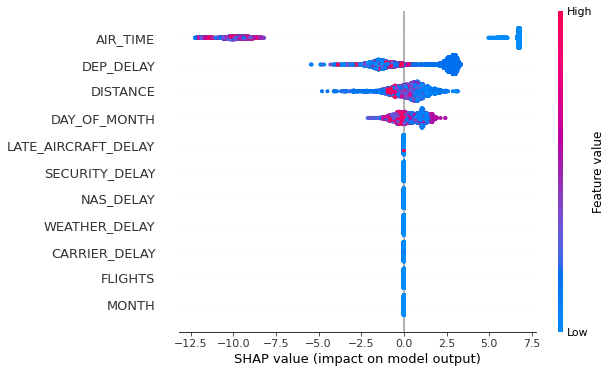

In [23]:
shap.summary_plot(shap_values, X_test)

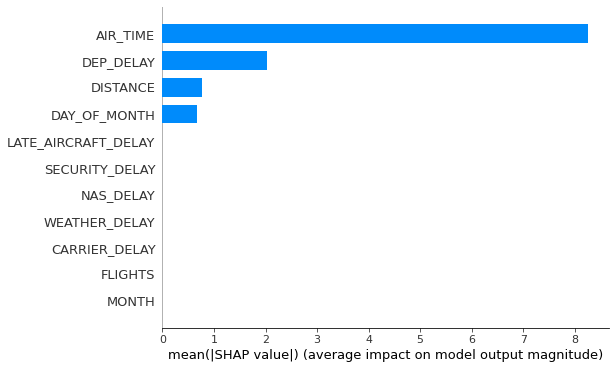

In [24]:
shap.summary_plot(shap_values, X_train, plot_type="bar")